In [19]:
# sytem lib
import os

import matplotlib.pyplot as plt

# common lib
import numpy as np
import segmentation_models_pytorch as smp

# torh lib
import torch
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

DATA_DIR = './dataset'

# determine the device to be used for training and evaluation
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == 'cuda' else False
# backbone NN
ENCODER = 'resnet34'
# image size for input NN
IMAGE_SIZE = 256

load_dotenv()

True

### Utilities

In [20]:
# helper function for data visualization


def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

# 1. Data

## 1.1 Download data

In [21]:
from google_drive_downloader import GoogleDriveDownloader as gdd

FILE_ID = os.getenv('FILE_ID')

if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.makedirs(DATA_DIR)
    dest_path = os.path.join(DATA_DIR, 'dataset.zip')
    gdd.download_file_from_google_drive(
        file_id=FILE_ID,
        dest_path=dest_path,
        unzip=True,
    )
    print('Done!')

## 1.2 Define dataset

In [22]:
from PIL import Image
from torch.utils.data import Dataset


class MedPatDataset(Dataset):
    def __init__(self, imagePaths, maskPaths, preprocessing, augmentation):
        # store the image and mask filepaths, and augmentation
        # transforms
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        self.preprocessing = preprocessing
        self.augmentation = augmentation

    def __len__(self):
        # return the number of total samples contained in the dataset
        return len(self.imagePaths)

    def __getitem__(self, idx):
        # grab the image path from the current index
        imagePath = self.imagePaths[idx]
        # load the image from disk, swap its channels from BGR to RGB,
        # and read the associated mask from disk in grayscale mode
        image = Image.open(imagePath)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.resize((IMAGE_SIZE, IMAGE_SIZE))
        image = np.array(image)
        mask = Image.open(self.maskPaths[idx])
        mask = mask.resize((IMAGE_SIZE, IMAGE_SIZE))
        mask = np.array(mask)
        class_label = float(np.sum(mask) > 0)
        mask = mask.reshape((mask.shape[0], mask.shape[1], 1))

        # check to see if we are applying any transformations
        if self.augmentation is not None:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # return a tuple of the image and its mask
        return (image, mask, class_label)

## 1.3 Split to train and test

In [23]:
TEST_SPLIT = 0.2


def list_full_paths(directory):
    return [os.path.join(directory, file) for file in os.listdir(directory)]


imagePaths = list_full_paths(os.path.join(DATA_DIR, 'images'))
maskPaths = list_full_paths(os.path.join(DATA_DIR, 'masks'))

train_img, test_img, train_masks, test_masks = train_test_split(
    imagePaths, maskPaths, test_size=TEST_SPLIT, random_state=42
)
print(f'Train size = {len(train_img)}')
print(f'Test size = {len(test_img)}')


Train size = 160
Test size = 40


Image and mask for class 0.0


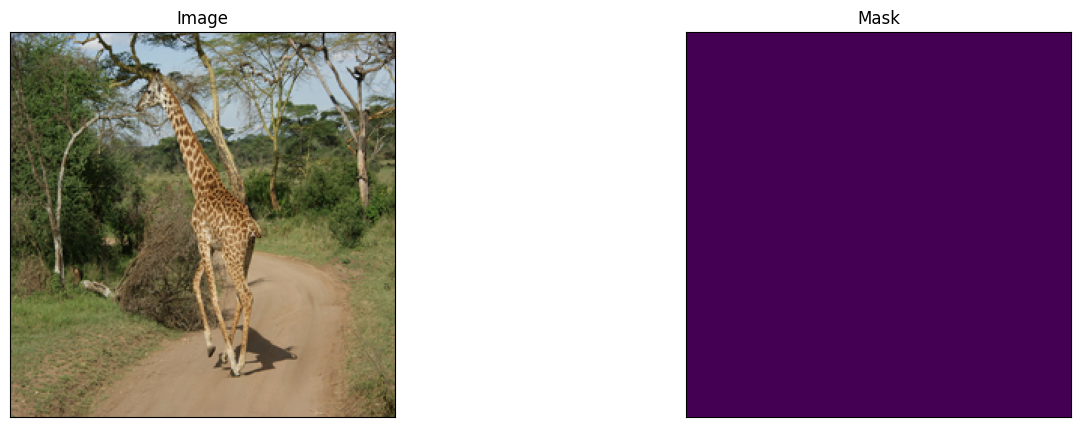

In [24]:
# just look on raw data
train_dataset = MedPatDataset(train_img, train_masks, None, None)
test_dataset = MedPatDataset(test_img, test_masks, None, None)

image, mask, class_label = train_dataset[1]  # get some sample
print(f'Image and mask for class {class_label}')
visualize(
    image=image,
    mask=mask.squeeze(),
)

Image and mask for class 1.0


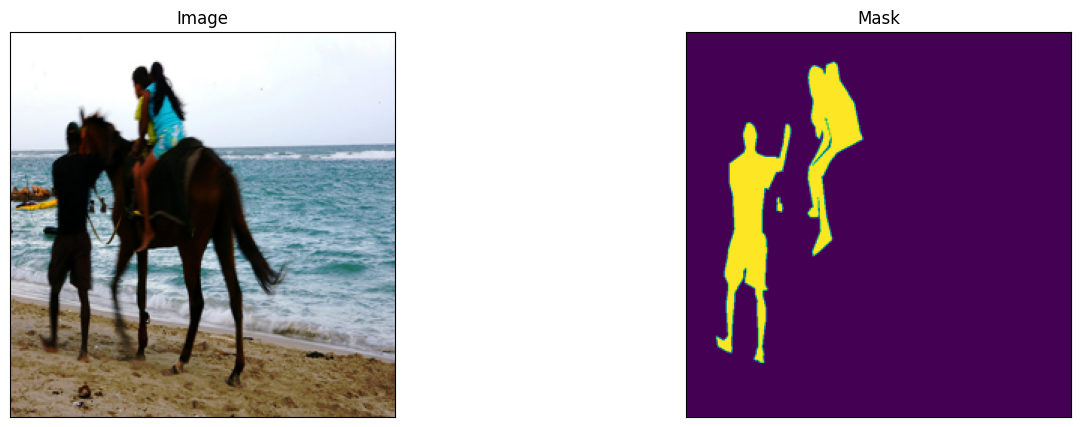

In [25]:
image, mask, class_label = train_dataset[10]  # get some sample
print(f'Image and mask for class {class_label}')
visualize(
    image=image,
    mask=mask.squeeze(),
)

## 1.4 Check class balance

In [26]:
train_class_1 = 0
for images, gt_masks, class_label in train_dataset:
    if class_label == 1:
        train_class_1 += 1
test_class_1 = 0
for images, gt_masks, class_label in test_dataset:
    if class_label == 1:
        test_class_1 += 1
print(
    f'proportion of positive class in train data {train_class_1/len(train_dataset):.4f}'
)
print(
    f'proportion of positive class in test data {test_class_1/len(test_dataset):.4f}'
)


proportion of positive class in train data 0.4875
proportion of positive class in test data 0.5500


## 1.5 Preprocessing and Augmentations

In [27]:
import albumentations as albu


def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(
            scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0
        ),
        albu.PadIfNeeded(
            min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, always_apply=True
        ),
        albu.RandomCrop(height=IMAGE_SIZE, width=IMAGE_SIZE, always_apply=True),
        albu.GaussNoise(p=0.2),
        albu.Perspective(p=0.5),
    ]
    return albu.Compose(train_transform, is_check_shapes=False)


def to_tensor(x, **kwargs):
    import torchvision.transforms as transforms

    transform = transforms.Compose([transforms.ToTensor()])

    return transform(x)


def get_preprocessing():
    _transform = [
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)


Image and mask for class 1.0


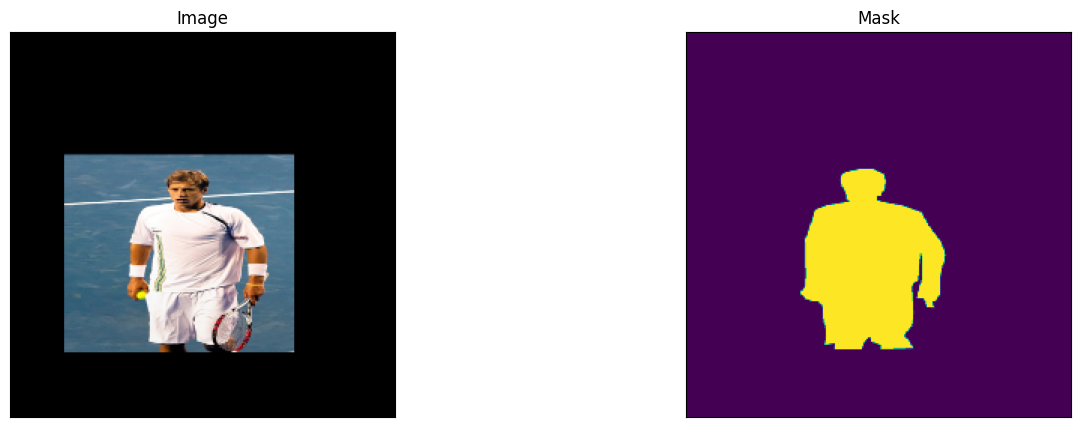

Image and mask for class 0.0


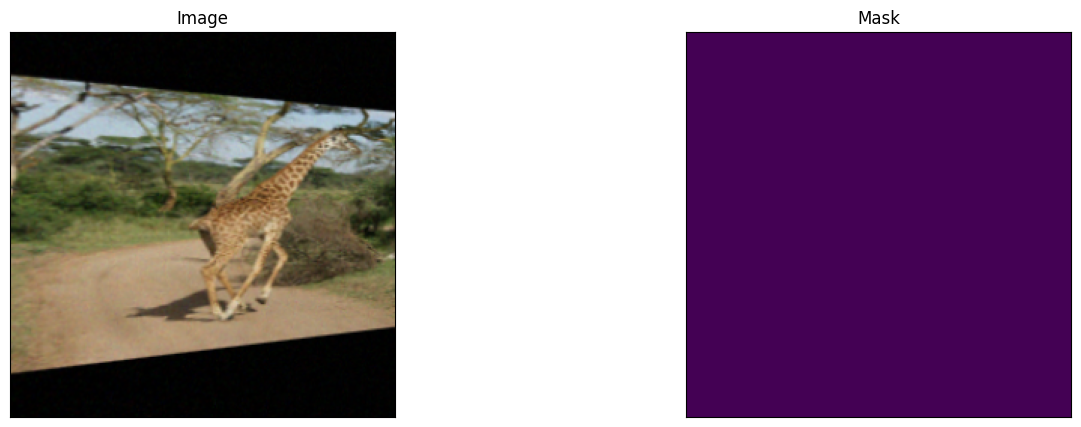

Image and mask for class 0.0


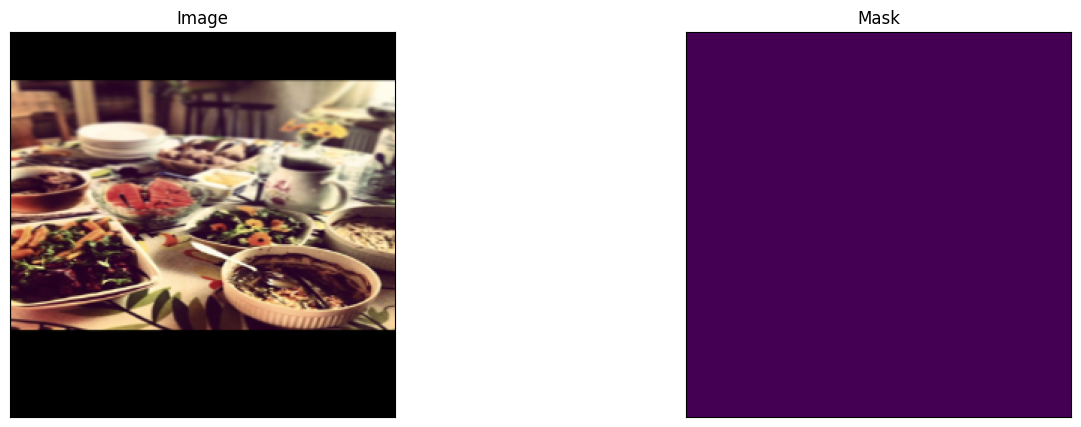

Image and mask for class 0.0


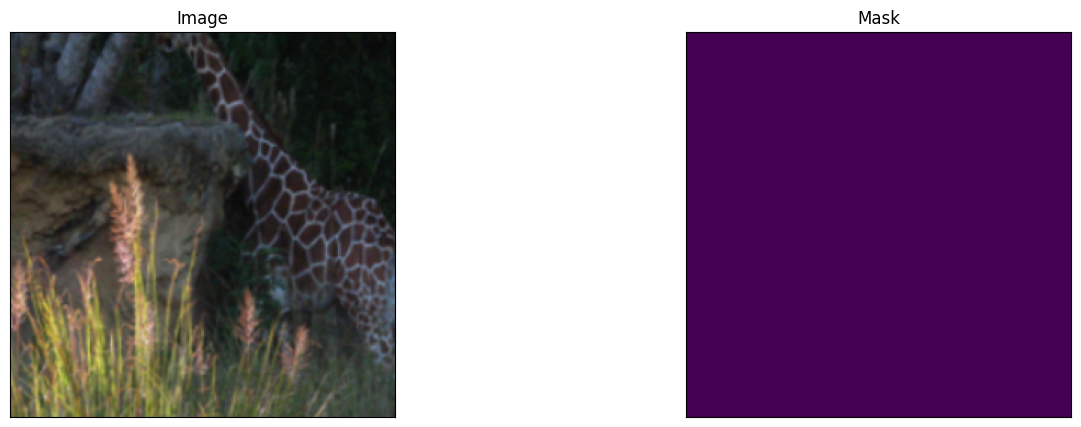

Image and mask for class 1.0


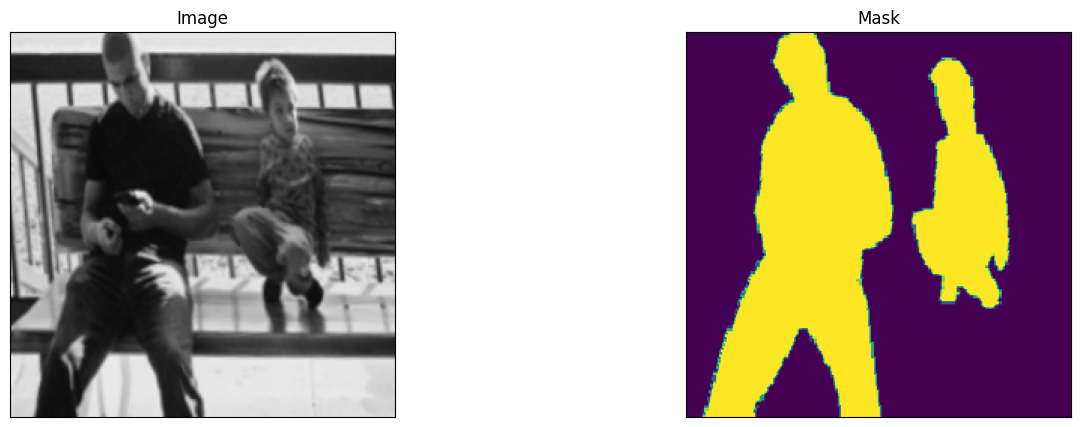

Image and mask for class 1.0


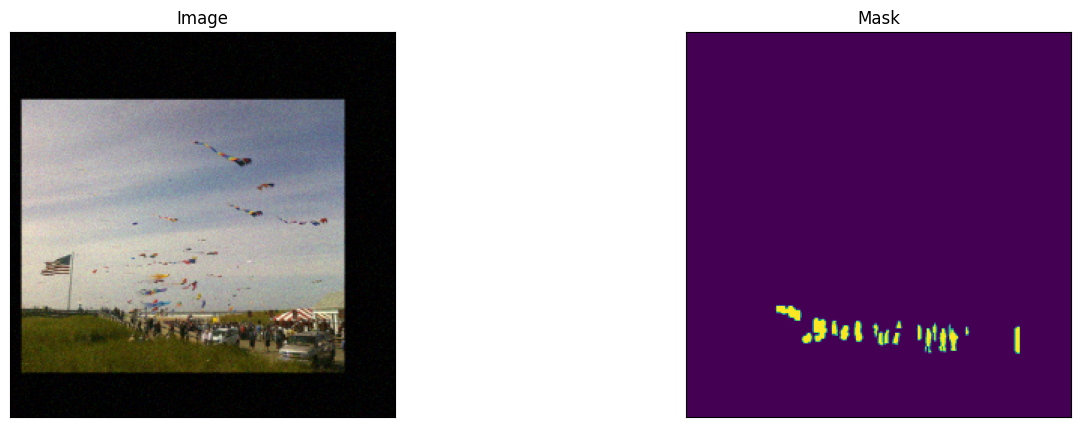

Image and mask for class 1.0


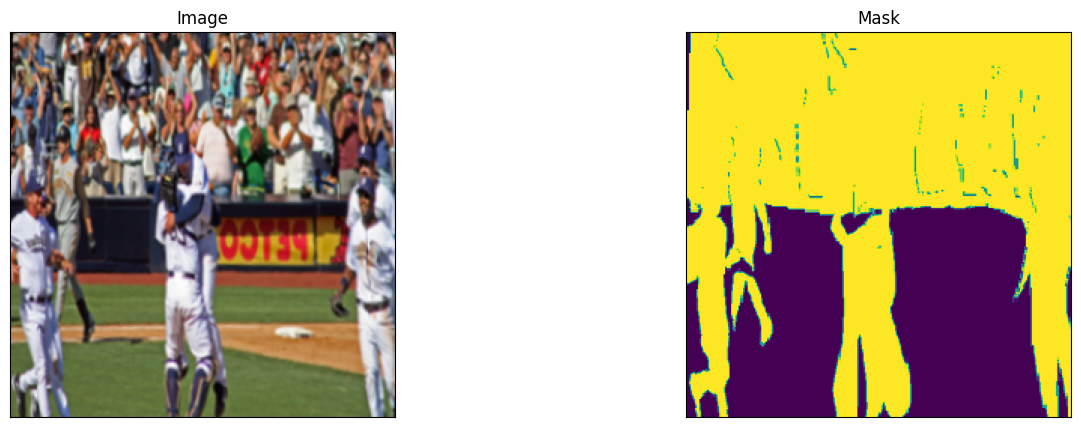

Image and mask for class 0.0


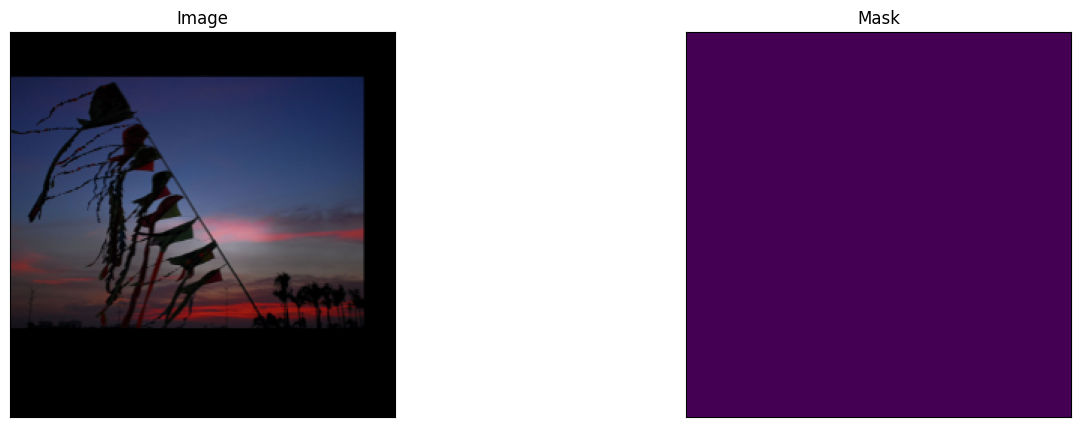

Image and mask for class 1.0


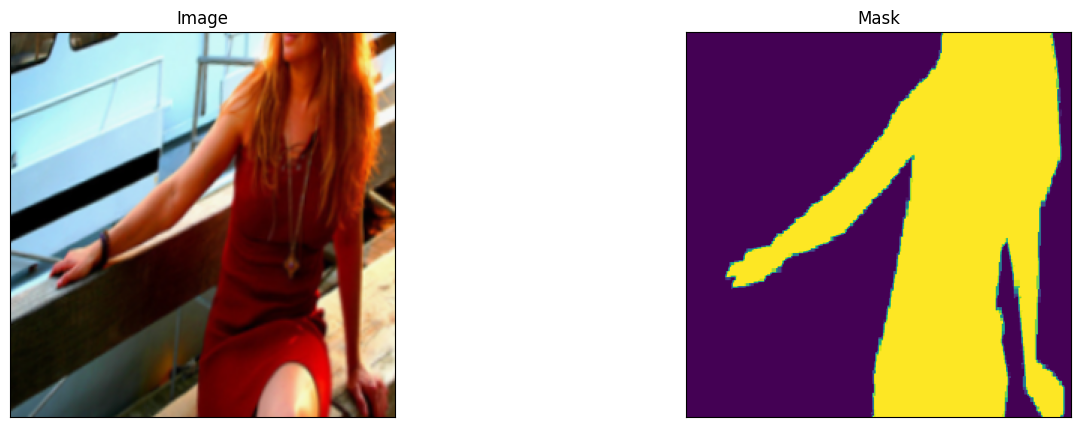

Image and mask for class 1.0


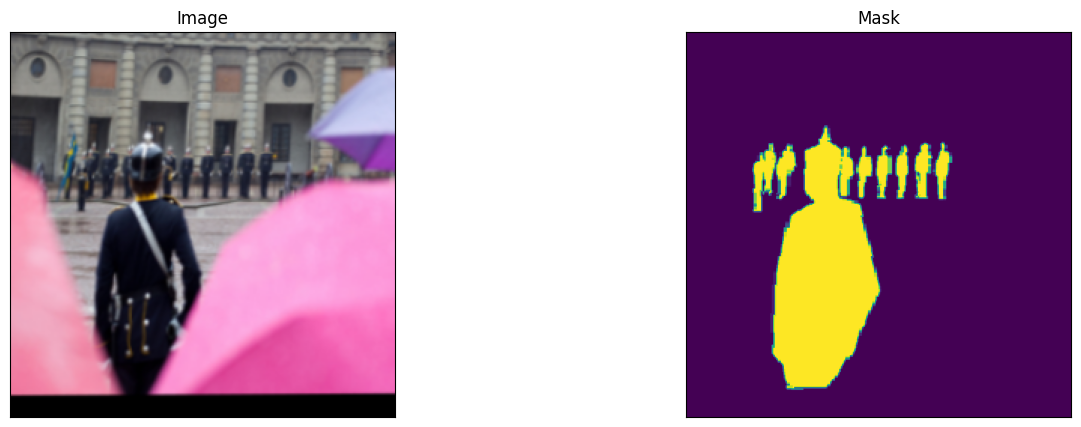

In [28]:
# visual check  work of augmentation
train_dataset = MedPatDataset(
    train_img,
    train_masks,
    preprocessing=None,  # get_preprocessing(preprocessing_fn),
    augmentation=get_training_augmentation(),
)
test_dataset = MedPatDataset(
    test_img,
    test_masks,
    preprocessing=None,
    augmentation=get_training_augmentation(),
)

# same image with different random transforms
for i in range(5):
    image, mask, class_label = train_dataset[i]
    print(f'Image and mask for class {class_label}')
    visualize(image=image, mask=mask.squeeze())

# same image with different random transforms
for i in range(5):
    image, mask, class_label = test_dataset[i]
    print(f'Image and mask for class {class_label}')
    visualize(image=image, mask=mask.squeeze())

# 2. Define and train model

In [29]:
CLASSES = ['human']
ACTIVATION = 'sigmoid'  # could be None for logits or 'softmax2d' for multiclass segmentation

aux_params = dict(
    pooling='avg',  # one of 'avg', 'max'
    dropout=0.5,  # dropout ratio, default is None
    classes=1,  # define number of output labels
    activation='sigmoid',
)

# create segmentation model with pretrained encoder
unet = smp.Unet(
    encoder_name=ENCODER,
    # encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    aux_params=aux_params,
).to(DEVICE)

In [30]:
unet

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [31]:
unet.segmentation_head

SegmentationHead(
  (0): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Identity()
  (2): Activation(
    (activation): Identity()
  )
)

In [32]:
# architecture of the neural network of the classifier. The output from the encoder is input to this classifier
unet.classification_head

ClassificationHead(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Dropout(p=0.5, inplace=True)
  (3): Linear(in_features=512, out_features=1, bias=True)
  (4): Activation(
    (activation): Sigmoid()
  )
)

In [33]:
INIT_LR = 0.05

# cross_entropy = nn.CrossEntropyLoss()
BCE = nn.BCEWithLogitsLoss()
DICE = smp.losses.DiceLoss(mode='binary')
opt_seg = Adam(
    [
        {'params': unet.encoder.parameters()},
        {'params': unet.decoder.parameters()},
        {'params': unet.segmentation_head.parameters()},
    ],
    lr=INIT_LR,
)
opt_cls = Adam([{'params': unet.classification_head.parameters()}], lr=INIT_LR)


def metrics(y_pred, y_test):
    from sklearn.metrics import accuracy_score, precision_score, recall_score

    return {
        'recall': recall_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'accuracy': accuracy_score(y_test, y_pred),
    }


In [34]:
import warnings

from torch.utils.data import DataLoader

warnings.filterwarnings('ignore')

BATCH_SIZE = 8
NUM_EPOCHS = 200

train_dataset = MedPatDataset(
    train_img,
    train_masks,
    preprocessing=get_preprocessing(),
    augmentation=get_training_augmentation(),
)
test_dataset = MedPatDataset(
    test_img,
    test_masks,
    preprocessing=get_preprocessing(),
    augmentation=get_training_augmentation(),
)


train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=PIN_MEMORY
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=PIN_MEMORY
)

print('[INFO] training the network...')
# history log
H = {
    'train_loss': [],
    'train_loss_seg': [],
    'train_loss_cls': [],
    'test_loss': [],
    'recall': [],
    'accuracy': [],
    'precision': [],
}
for e in tqdm(range(NUM_EPOCHS)):
    unet.train()
    # initialize the total training and validation loss
    train_loss = 0
    train_loss_seg = 0
    train_loss_cls = 0
    test_loss = 0
    recall = 0
    accuracy = 0
    precision = 0
    train_steps = 0
    test_steps = 0

    for images, gt_masks, class_label in train_loader:
        train_steps += 1

        (images, gt_masks, class_label) = (
            images.to(DEVICE, dtype=torch.float),
            gt_masks.to(DEVICE),
            class_label.to(DEVICE),
        )

        predicted_mask, _ = unet(images)

        loss_seg = DICE(predicted_mask, gt_masks)

        opt_seg.zero_grad()
        loss_seg.backward()
        opt_seg.step()

        _, labels = unet(images)

        loss_cls = BCE(labels, class_label.unsqueeze(1))

        opt_cls.zero_grad()
        loss_cls.backward()
        opt_cls.step()

        loss = loss_seg + loss_cls

        train_loss += loss
        train_loss_seg += loss_seg
        train_loss_cls += loss_cls
    # set the model in evaluation mode
    unet.eval()
    # switch off autograd
    with torch.no_grad():
        for images, gt_masks, class_label in test_loader:
            test_steps += 1
            (images, gt_masks, class_label) = (
                images.to(DEVICE, dtype=torch.float),
                gt_masks.to(DEVICE),
                class_label.to(DEVICE),
            )
            predicted_mask, labels = unet(images)

            loss_test = DICE(predicted_mask, gt_masks)
            +BCE(labels, class_label.unsqueeze(1))
            test_loss += loss_test

            # metric calc
            y_pred = labels.view(-1).cpu().detach().numpy().round()
            y_true = class_label.view(-1).cpu().detach().numpy()
            batch_metircs = metrics(y_pred, y_true)
            precision += batch_metircs['precision']
            accuracy += batch_metircs['accuracy']
            recall += batch_metircs['recall']

            if e > 1 and e % 10 == 0:
                torch.save(unet, 'unet_medpat.pt')

    # calculate the average training and test loss
    avg_train_loss = train_loss / train_steps
    avg_test_loss = test_loss / test_steps
    avg_loss_seg = train_loss_seg / train_steps
    avg_loss_cls = train_loss_cls / train_steps
    avg_recall = recall / test_steps
    avg_precision = precision / test_steps
    avg_accuracy = accuracy / test_steps
    H['train_loss'].append(avg_train_loss.cpu().detach().numpy())
    H['train_loss_seg'].append(avg_loss_seg.cpu().detach().numpy())
    H['train_loss_cls'].append(avg_loss_cls.cpu().detach().numpy())
    H['test_loss'].append(avg_test_loss.cpu().detach().numpy())
    H['recall'].append(avg_recall)
    H['precision'].append(avg_precision)
    H['accuracy'].append(avg_accuracy)

    torch.save(unet, 'unet_medpat.pt')

    if e % 10 == 0:
        print(f'[INFO] EPOCH: {e+1}/{NUM_EPOCHS}')
        print(
            f'Train loss: {avg_train_loss:.6f}, test loss {avg_test_loss:.6f}'
        )
        print(
            f'Train loss seg: {avg_loss_seg:.6f}, train loss cls {avg_loss_cls:.6f}'
        )
        print(
            f'EPOCH metrics: accuracy {avg_accuracy:.4f}, recall {avg_recall:.4f}, precision {avg_precision:.4f}'
        )


[INFO] training the network...


  0%|          | 1/200 [01:00<3:21:14, 60.67s/it]

[INFO] EPOCH: 1/200
Train loss: 1.585521, test loss 0.790572
Train loss seg: 0.887647, train loss cls 0.697875
EPOCH metrics: accuracy 0.4500, recall 0.0000, precision 0.0000


  6%|▌         | 11/200 [02:49<36:13, 11.50s/it] 

[INFO] EPOCH: 11/200
Train loss: 1.580245, test loss 0.785332
Train loss seg: 0.887098, train loss cls 0.693147
EPOCH metrics: accuracy 0.4500, recall 0.0000, precision 0.0000


 10%|█         | 21/200 [04:39<33:47, 11.33s/it]

[INFO] EPOCH: 21/200
Train loss: 1.580381, test loss 0.770874
Train loss seg: 0.887234, train loss cls 0.693147
EPOCH metrics: accuracy 0.4500, recall 0.0000, precision 0.0000


 16%|█▌        | 31/200 [06:26<30:32, 10.84s/it]

[INFO] EPOCH: 31/200
Train loss: 1.549478, test loss 0.727039
Train loss seg: 0.856331, train loss cls 0.693147
EPOCH metrics: accuracy 0.4500, recall 0.0000, precision 0.0000


 20%|██        | 41/200 [08:14<28:57, 10.93s/it]

[INFO] EPOCH: 41/200
Train loss: 1.496847, test loss 0.742427
Train loss seg: 0.803700, train loss cls 0.693147
EPOCH metrics: accuracy 0.4500, recall 0.0000, precision 0.0000


 26%|██▌       | 51/200 [10:01<26:46, 10.78s/it]

[INFO] EPOCH: 51/200
Train loss: 1.451868, test loss 0.682303
Train loss seg: 0.758720, train loss cls 0.693147
EPOCH metrics: accuracy 0.4500, recall 0.0000, precision 0.0000


 30%|███       | 61/200 [11:46<24:43, 10.67s/it]

[INFO] EPOCH: 61/200
Train loss: 1.466696, test loss 0.645205
Train loss seg: 0.773549, train loss cls 0.693147
EPOCH metrics: accuracy 0.4500, recall 0.0000, precision 0.0000


 36%|███▌      | 71/200 [13:32<23:12, 10.79s/it]

[INFO] EPOCH: 71/200
Train loss: 1.425567, test loss 0.686439
Train loss seg: 0.732420, train loss cls 0.693147
EPOCH metrics: accuracy 0.4500, recall 0.0000, precision 0.0000


 40%|████      | 81/200 [15:19<21:19, 10.75s/it]

[INFO] EPOCH: 81/200
Train loss: 1.416874, test loss 0.579126
Train loss seg: 0.723727, train loss cls 0.693147
EPOCH metrics: accuracy 0.4500, recall 0.0000, precision 0.0000


 46%|████▌     | 91/200 [17:04<19:25, 10.69s/it]

[INFO] EPOCH: 91/200
Train loss: 1.401432, test loss 0.618230
Train loss seg: 0.708284, train loss cls 0.693147
EPOCH metrics: accuracy 0.4500, recall 0.0000, precision 0.0000


 50%|█████     | 101/200 [18:50<17:36, 10.67s/it]

[INFO] EPOCH: 101/200
Train loss: 1.346265, test loss 0.730378
Train loss seg: 0.653118, train loss cls 0.693147
EPOCH metrics: accuracy 0.4500, recall 0.0000, precision 0.0000


 56%|█████▌    | 111/200 [20:36<15:54, 10.73s/it]

[INFO] EPOCH: 111/200
Train loss: 1.403350, test loss 0.589022
Train loss seg: 0.710203, train loss cls 0.693147
EPOCH metrics: accuracy 0.4500, recall 0.0000, precision 0.0000


 60%|██████    | 121/200 [22:22<14:05, 10.70s/it]

[INFO] EPOCH: 121/200
Train loss: 1.431609, test loss 0.591684
Train loss seg: 0.738462, train loss cls 0.693147
EPOCH metrics: accuracy 0.4500, recall 0.0000, precision 0.0000


 66%|██████▌   | 131/200 [24:07<12:19, 10.71s/it]

[INFO] EPOCH: 131/200
Train loss: 1.426798, test loss 0.727574
Train loss seg: 0.733650, train loss cls 0.693147
EPOCH metrics: accuracy 0.4500, recall 0.0000, precision 0.0000


 70%|███████   | 141/200 [25:54<10:36, 10.79s/it]

[INFO] EPOCH: 141/200
Train loss: 1.384763, test loss 0.641195
Train loss seg: 0.691616, train loss cls 0.693147
EPOCH metrics: accuracy 0.4500, recall 0.0000, precision 0.0000


 76%|███████▌  | 151/200 [27:39<08:45, 10.72s/it]

[INFO] EPOCH: 151/200
Train loss: 1.362878, test loss 0.528255
Train loss seg: 0.669730, train loss cls 0.693147
EPOCH metrics: accuracy 0.4500, recall 0.0000, precision 0.0000


 80%|████████  | 161/200 [29:25<06:55, 10.65s/it]

[INFO] EPOCH: 161/200
Train loss: 1.381554, test loss 0.661007
Train loss seg: 0.688407, train loss cls 0.693147
EPOCH metrics: accuracy 0.4500, recall 0.0000, precision 0.0000


 86%|████████▌ | 171/200 [31:10<05:08, 10.65s/it]

[INFO] EPOCH: 171/200
Train loss: 1.355585, test loss 0.669257
Train loss seg: 0.662438, train loss cls 0.693147
EPOCH metrics: accuracy 0.4500, recall 0.0000, precision 0.0000


 90%|█████████ | 181/200 [32:56<03:26, 10.85s/it]

[INFO] EPOCH: 181/200
Train loss: 1.391506, test loss 0.569236
Train loss seg: 0.698359, train loss cls 0.693147
EPOCH metrics: accuracy 0.4500, recall 0.0000, precision 0.0000


 96%|█████████▌| 191/200 [34:42<01:35, 10.66s/it]

[INFO] EPOCH: 191/200
Train loss: 1.404714, test loss 0.563443
Train loss seg: 0.711566, train loss cls 0.693147
EPOCH metrics: accuracy 0.4500, recall 0.0000, precision 0.0000


100%|██████████| 200/200 [36:16<00:00, 10.88s/it]


# 3. Plots grapths loss function and metrisc

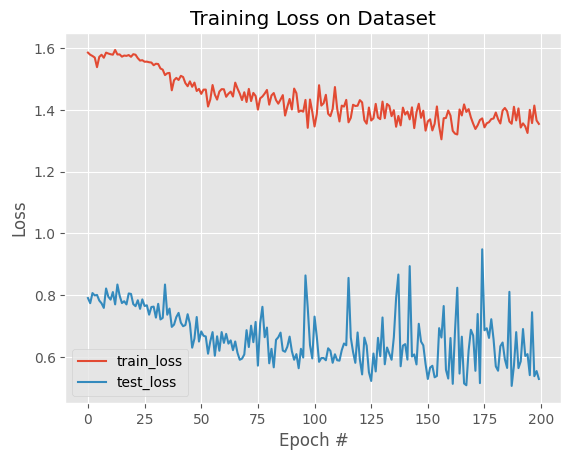

In [35]:
# plot the training/test loss
plt.style.use('ggplot')
plt.figure()
plt.plot(H['train_loss'], label='train_loss')
plt.plot(H['test_loss'], label='test_loss')
plt.title('Training Loss on Dataset')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend(loc='lower left')


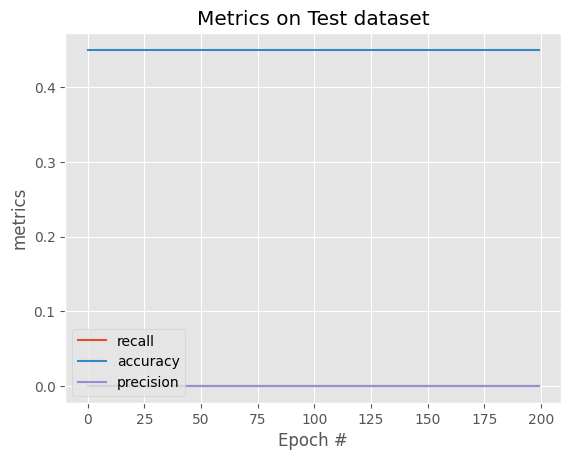

In [36]:
# plot the metrics
plt.style.use('ggplot')
plt.figure()
plt.plot(H['recall'], label='recall')
plt.plot(H['accuracy'], label='accuracy')
plt.plot(H['precision'], label='precision')
plt.title('Metrics on Test dataset')
plt.xlabel('Epoch #')
plt.ylabel('metrics')
plt.legend(loc='lower left')

# 4. Visualize predictions

In [37]:
def classify_image(path_image, path_model):
    import cv2
    import matplotlib.pyplot as plt
    import numpy as np
    import torch

    image_initial = cv2.imread(path_image)
    image = cv2.cvtColor(image_initial, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (320, 320))
    image = np.transpose(image, (2, 0, 1)).astype('float32')
    image = np.expand_dims(image, 0)
    image = torch.from_numpy(image)

    mask_real = cv2.imread(
        path_image.replace('images', 'masks').replace('jpg', 'png'), 0
    )
    class_label = int((np.sum(mask_real) > 0))

    unet = torch.load(path_model).cpu()
    unet.eval()
    # switch off autograd
    with torch.no_grad():
        predicted_mask, pred_label = unet(image)
        predicted_mask = predicted_mask.squeeze()
        predicted_mask = torch.sigmoid(predicted_mask).numpy()
        # filter out the weak predictions and convert them to integers
        predicted_mask = predicted_mask.round()
        predicted_mask = predicted_mask.astype(np.uint8)
        predicted_mask = np.expand_dims(predicted_mask, 0)
        pred_label = int(torch.sigmoid(pred_label).round())

    # prepare a plot for visualization
    # pred_label = -1
    print(f'Prediction class {pred_label} - real class {class_label}')
    plt.figure(figsize=(16, 5))
    # image
    plt.subplot(1, 3, 1)
    plt.xticks([])
    plt.yticks([])
    plt.title('Image')
    plt.imshow(image_initial)
    # real mask
    plt.subplot(1, 3, 2)
    plt.xticks([])
    plt.yticks([])
    plt.title('Real mask')
    plt.imshow(mask_real)
    # predicted mask
    plt.subplot(1, 3, 3)
    plt.xticks([])
    plt.yticks([])
    plt.title('Predicted mask')
    plt.imshow(predicted_mask[0])
    plt.show()

Prediction class 0 - real class 0


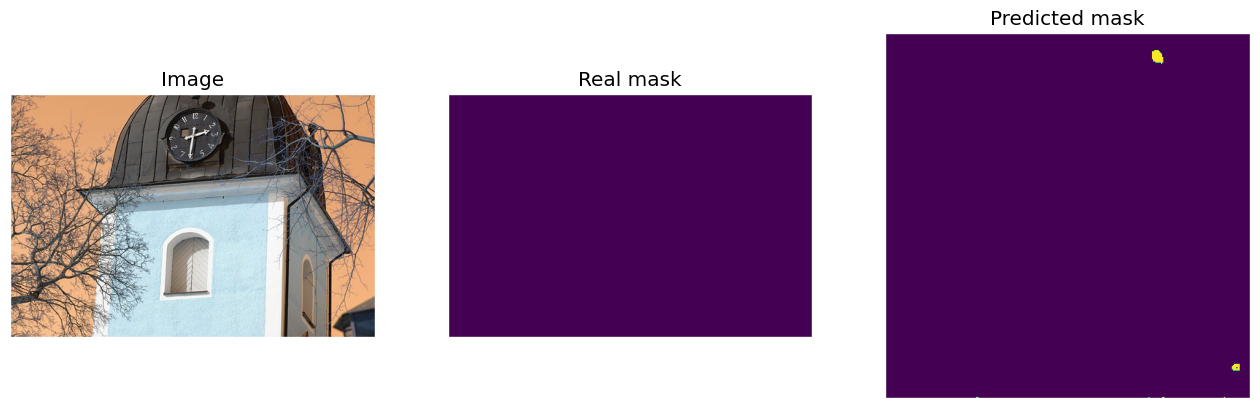

Prediction class 0 - real class 1


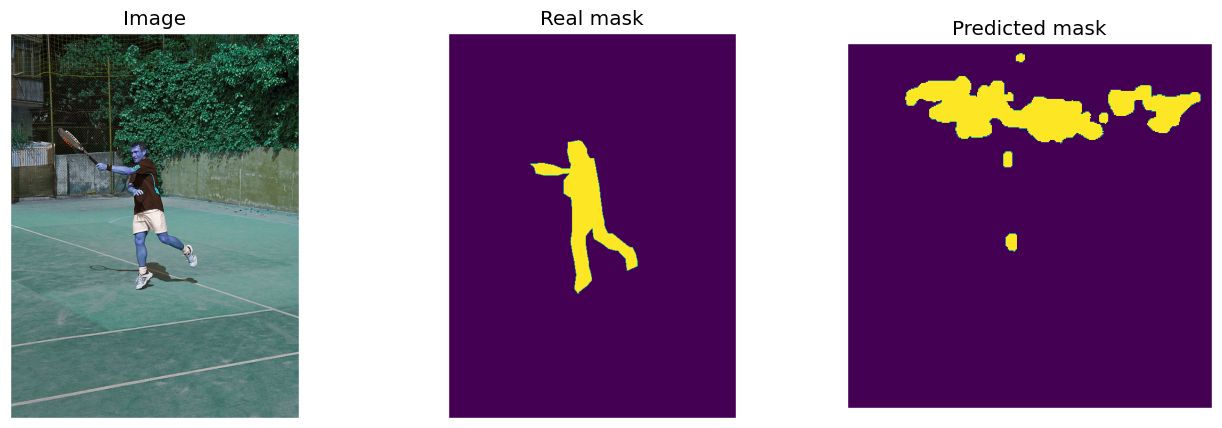

In [38]:
# no human
classify_image(
    path_image=os.path.join(DATA_DIR, 'images', '000000009509.jpg'),
    path_model='unet_medpat.pt',
)

# human
classify_image(
    path_image=os.path.join(DATA_DIR, 'images', '000000545525.jpg'),
    path_model='unet_medpat.pt',
)

Prediction class 0 - real class 1


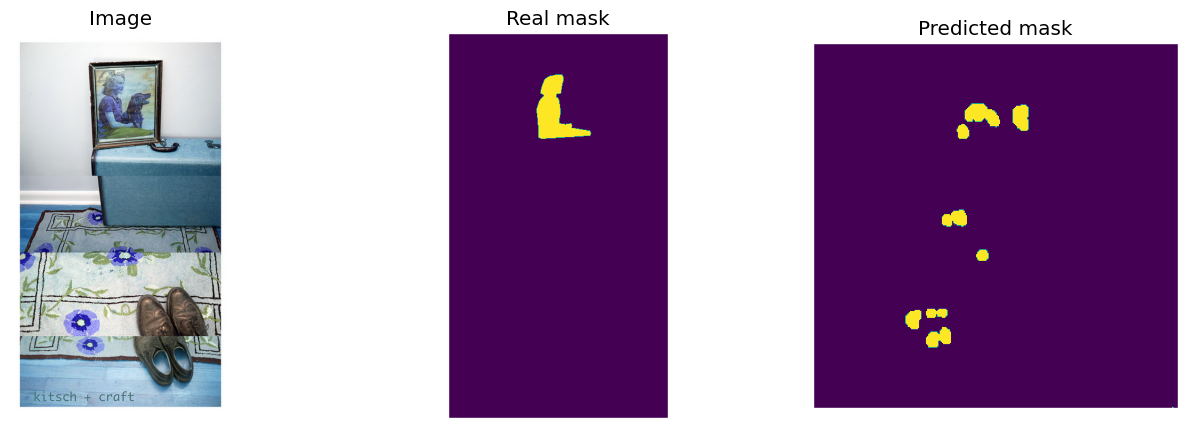

In [39]:
classify_image(
    path_image=os.path.join(DATA_DIR, 'images', '000000535650.jpg'),
    path_model='unet_medpat.pt',
)